In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from keras.layers import Activation, Dense
import gc
from keras.models import Sequential
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,RocCurveDisplay,ConfusionMatrixDisplay,confusion_matrix,roc_auc_score,accuracy_score
from sklearn.ensemble import (AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier,VotingClassifier)
from IPython.display import clear_output
from sklearn import model_selection

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import os, psutil

import os
for dirname, _, filenames in os.walk('/NSL_KDD/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

In [3]:
%%time

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )

def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

print('Function built')

Function built
CPU times: user 66 µs, sys: 7 µs, total: 73 µs
Wall time: 78.2 µs


In [4]:
df_train = pd.read_csv("NSL_KDD/KDDTrain+.txt")
df_train.columns = columns
df_test = pd.read_csv("NSL_KDD/KDDTest+.txt")
df_test.columns = columns

df_train = reduce_memory_usage(df_train, verbose=True)
df_test = reduce_memory_usage(df_test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 12.13 Mb (70.6% reduction)
Mem. usage decreased to 2.17 Mb (70.6% reduction)
memory GB:0.77
Memory reduced


In [5]:
df_train.shape

(125972, 43)

In [6]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.000000,0.600098,0.879883,0.000000,0.000000,0.000000,0.0,0.000000,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.099976,0.049988,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.000000,0.000000,0.029999,0.040009,0.029999,0.010002,0.0,0.010002,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.070007,0.070007,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,neptune,21


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int32  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int32  
 5   dst_bytes                    125972 non-null  int32  
 6   land                         125972 non-null  int8   
 7   wrong_fragment               125972 non-null  int8   
 8   urgent                       125972 non-null  int8   
 9   hot                          125972 non-null  int8   
 10  num_failed_logins            125972 non-null  int8   
 11  logged_in                    125972 non-null  int8   
 12  num_compromised              125972 non-null  int16  
 13 

In [8]:
df_train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22543 entries, 0 to 22542
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22543 non-null  int32  
 1   protocol_type                22543 non-null  object 
 2   service                      22543 non-null  object 
 3   flag                         22543 non-null  object 
 4   src_bytes                    22543 non-null  int32  
 5   dst_bytes                    22543 non-null  int32  
 6   land                         22543 non-null  int8   
 7   wrong_fragment               22543 non-null  int8   
 8   urgent                       22543 non-null  int8   
 9   hot                          22543 non-null  int8   
 10  num_failed_logins            22543 non-null  int8   
 11  logged_in                    22543 non-null  int8   
 12  num_compromised              22543 non-null  int16  
 13  root_shell      

In [10]:
df_test.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

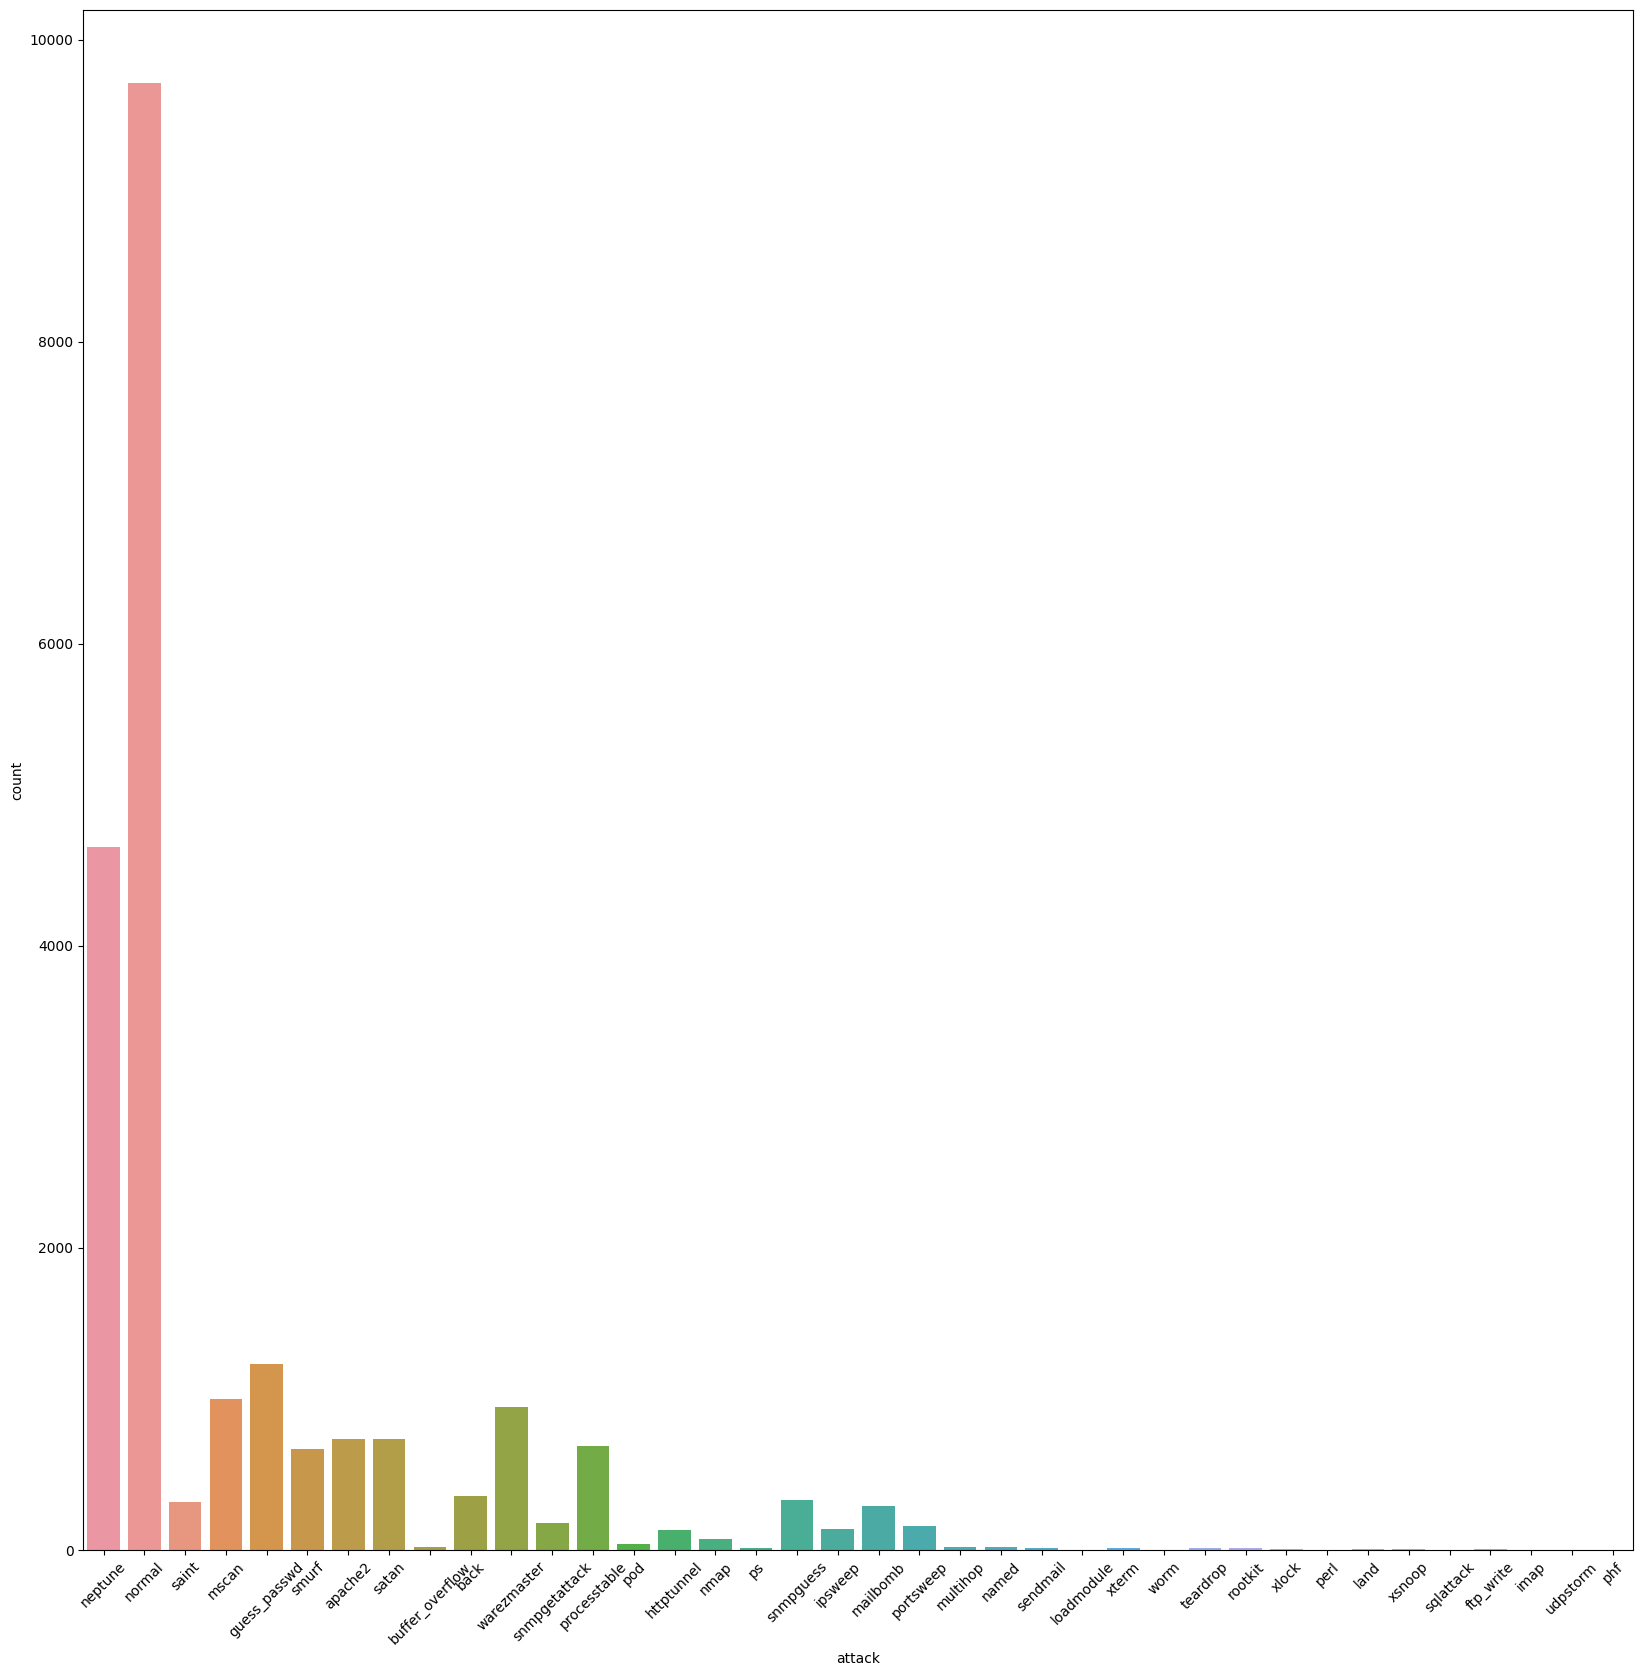

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,20))
sns.countplot(x=df_test['attack'])
plt.xticks(rotation = 45)
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['protocol_type'] = le.fit_transform(df_train['protocol_type'])
df_test['protocol_type'] = le.transform(df_test['protocol_type'])
df_train['service'] = le.fit_transform(df_train['service'])
df_test['service'] =le.transform(df_test['service'])
df_train['flag'] = le.fit_transform(df_train['flag'])
df_test['flag'] = le.transform(df_test['flag'])

In [13]:
label = []
for i in df_train.attack :
  if i == 'normal':
    label.append(0)
  else:
    label.append(1)
df_train['label'] = label 

In [14]:
label_test = []
for i in df_test.attack :
  if i == 'normal':
    label_test.append(0)
  else:
    label_test.append(1)
df_test['label'] = label_test

In [15]:
df_train.drop('attack',axis = 1,inplace = True)
df_test.drop('attack',axis = 1,inplace = True)

In [16]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,label
0,0,1,49,1,0,0,0,0,0,0,...,0.000000,0.059998,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,21,1
1,2,1,20,9,12983,0,0,0,0,0,...,0.609863,0.040009,0.609863,0.020004,0.000000,0.0,0.000000,0.000000,21,0
2,0,0,14,9,20,0,0,0,0,0,...,1.000000,0.000000,1.000000,0.280029,0.000000,0.0,0.000000,0.000000,15,1
3,1,1,60,2,0,15,0,0,0,0,...,0.310059,0.170044,0.029999,0.020004,0.000000,0.0,0.830078,0.709961,11,1
4,0,1,24,9,267,14515,0,0,0,0,...,1.000000,0.000000,0.010002,0.029999,0.010002,0.0,0.000000,0.000000,21,0


<Axes: >

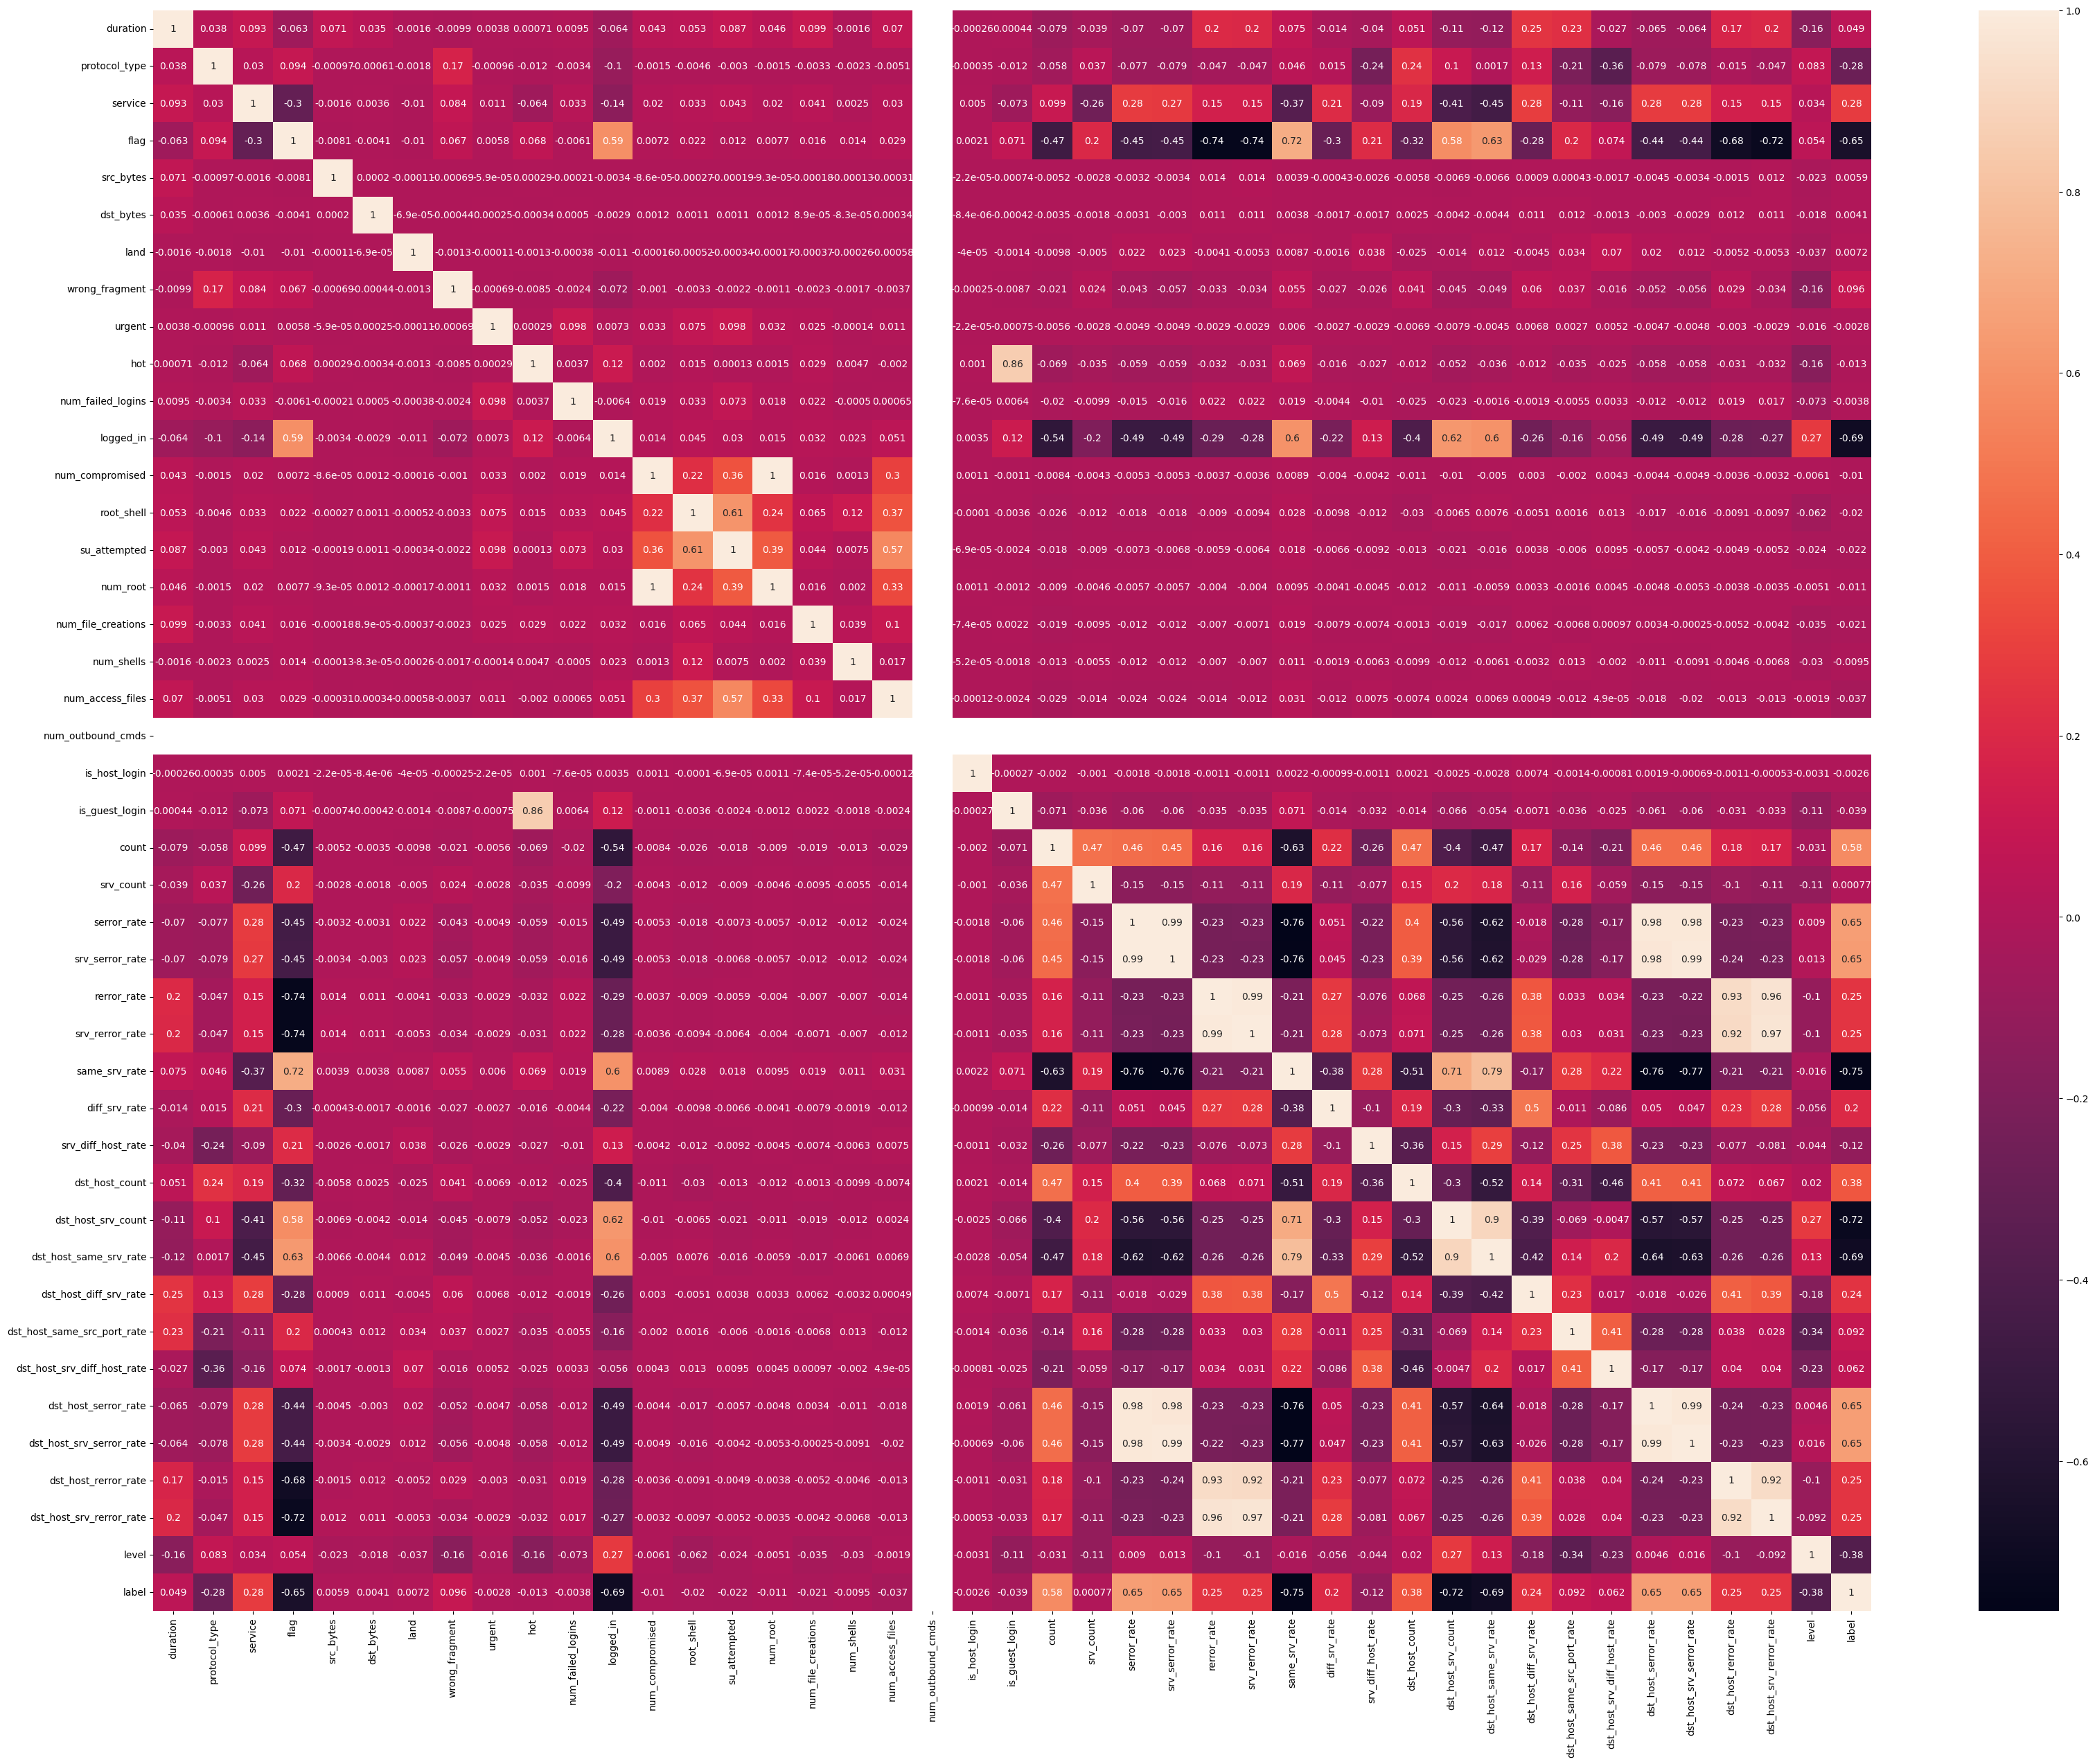

In [17]:
plt.figure(figsize=(40,30))
sns.heatmap(df_train.corr(), annot=True)

In [18]:
df_test["kfold"] = -1
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=666)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_test)):
  df_test.loc[valid_indicies, "kfold"] = fold
features = [x for x in df_test.columns.values if x[0]=="f"]

In [19]:
useful_features = [c for c in df_test.columns if c not in ("label", "kfold")]

In [20]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,label,kfold
0,0,1,49,1,0,0,0,0,0,0,...,0.059998,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,21,1,4
1,2,1,20,9,12983,0,0,0,0,0,...,0.040009,0.609863,0.020004,0.000000,0.0,0.000000,0.000000,21,0,0
2,0,0,14,9,20,0,0,0,0,0,...,0.000000,1.000000,0.280029,0.000000,0.0,0.000000,0.000000,15,1,2
3,1,1,60,2,0,15,0,0,0,0,...,0.170044,0.029999,0.020004,0.000000,0.0,0.830078,0.709961,11,1,1
4,0,1,24,9,267,14515,0,0,0,0,...,0.000000,0.010002,0.029999,0.010002,0.0,0.000000,0.000000,21,0,0


In [21]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import optuna
from sklearn import preprocessing
from xgboost import XGBClassifier
import xgboost as xgb
def run(trial):
    fold = 0
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)

    xtrain = df_test[df_test.kfold != fold].reset_index(drop=True)
    xvalid = df_test[df_test.kfold == fold].reset_index(drop=True)

    ytrain = xtrain.label
    yvalid = xvalid.label

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]


    model = XGBClassifier(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_metric = "aucpr",eval_set=[(xvalid, yvalid)], verbose=1000)
    preds_valid = model.predict(xvalid)
    acc = accuracy_score(yvalid, preds_valid)
    return acc

In [23]:
study = optuna.create_study(direction="minimize")
study.optimize(run, n_trials=5)

[I 2023-05-10 22:56:41,258] A new study created in memory with name: no-name-ef40aaae-3f8f-41f4-addf-365f13773cdb
<ipython-input-22-a3daa2a3894d>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
<ipython-input-22-a3daa2a3894d>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/loca

[22:56:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-aucpr:0.94888
[1000]	validation_0-aucpr:0.99993
[1754]	validation_0-aucpr:0.99993


[I 2023-05-10 22:56:45,494] Trial 0 finished with value: 0.9955644267021513 and parameters: {'learning_rate': 0.12943577597409645, 'reg_lambda': 2.047756025875471, 'reg_alpha': 0.000235175763032697, 'subsample': 0.589609346288722, 'colsample_bytree': 0.5109051311857906, 'max_depth': 2}. Best is trial 0 with value: 0.9955644267021513.


[22:56:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-aucpr:0.95020


<ipython-input-22-a3daa2a3894d>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
<ipython-input-22-a3daa2a3894d>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is dep

[1000]	validation_0-aucpr:0.99853
[2000]	validation_0-aucpr:0.99949
[3000]	validation_0-aucpr:0.99972
[4000]	validation_0-aucpr:0.99979
[5000]	validation_0-aucpr:0.99984
[6000]	validation_0-aucpr:0.99988
[6999]	validation_0-aucpr:0.99989


[I 2023-05-10 22:57:19,776] Trial 1 finished with value: 0.9944555333776891 and parameters: {'learning_rate': 0.012781458755179092, 'reg_lambda': 10.571211259928813, 'reg_alpha': 0.011092411411489363, 'subsample': 0.858629562250257, 'colsample_bytree': 0.7518929568522817, 'max_depth': 2}. Best is trial 1 with value: 0.9944555333776891.


[22:57:19] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-aucpr:0.99013


<ipython-input-22-a3daa2a3894d>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
<ipython-input-22-a3daa2a3894d>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is dep

[1000]	validation_0-aucpr:0.99990
[1187]	validation_0-aucpr:0.99990


[I 2023-05-10 22:57:22,682] Trial 2 finished with value: 0.994899090707474 and parameters: {'learning_rate': 0.027698080461691678, 'reg_lambda': 0.21101189415072732, 'reg_alpha': 0.00013709882803311117, 'subsample': 0.11154419084490817, 'colsample_bytree': 0.8341668078188644, 'max_depth': 6}. Best is trial 1 with value: 0.9944555333776891.


[22:57:22] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-aucpr:0.98668


<ipython-input-22-a3daa2a3894d>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
<ipython-input-22-a3daa2a3894d>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is dep

[1000]	validation_0-aucpr:0.99995
[2000]	validation_0-aucpr:0.99996
[2460]	validation_0-aucpr:0.99996


[I 2023-05-10 22:57:28,344] Trial 3 finished with value: 0.9962297626968286 and parameters: {'learning_rate': 0.013293989381279608, 'reg_lambda': 1.422330462272408e-07, 'reg_alpha': 1.2918191854959663e-05, 'subsample': 0.5425450573285608, 'colsample_bytree': 0.7524383317275801, 'max_depth': 4}. Best is trial 1 with value: 0.9944555333776891.
<ipython-input-22-a3daa2a3894d>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
<ipython-input-22-a3daa2a3894d>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/usr/local/lib/pyt

[22:57:28] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-aucpr:0.92123
[767]	validation_0-aucpr:0.99993


[I 2023-05-10 22:57:30,757] Trial 4 finished with value: 0.9951208693723663 and parameters: {'learning_rate': 0.15493816522213277, 'reg_lambda': 2.023429274686326e-06, 'reg_alpha': 0.008417242079755794, 'subsample': 0.9438645074438213, 'colsample_bytree': 0.1595119754854757, 'max_depth': 4}. Best is trial 1 with value: 0.9944555333776891.


In [24]:
study.best_params

{'learning_rate': 0.012781458755179092,
 'reg_lambda': 10.571211259928813,
 'reg_alpha': 0.011092411411489363,
 'subsample': 0.858629562250257,
 'colsample_bytree': 0.7518929568522817,
 'max_depth': 2}

In [25]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,label,kfold
0,0,1,49,1,0,0,0,0,0,0,...,0.059998,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,21,1,4
1,2,1,20,9,12983,0,0,0,0,0,...,0.040009,0.609863,0.020004,0.000000,0.0,0.000000,0.000000,21,0,0
2,0,0,14,9,20,0,0,0,0,0,...,0.000000,1.000000,0.280029,0.000000,0.0,0.000000,0.000000,15,1,2
3,1,1,60,2,0,15,0,0,0,0,...,0.170044,0.029999,0.020004,0.000000,0.0,0.830078,0.709961,11,1,1
4,0,1,24,9,267,14515,0,0,0,0,...,0.000000,0.010002,0.029999,0.010002,0.0,0.000000,0.000000,21,0,0


In [26]:
print(len(useful_features))

42


In [27]:
df_test.shape

(22543, 44)

In [28]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,label,kfold
0,0,1,49,1,0,0,0,0,0,0,...,0.059998,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,21,1,4
1,2,1,20,9,12983,0,0,0,0,0,...,0.040009,0.609863,0.020004,0.000000,0.0,0.000000,0.000000,21,0,0
2,0,0,14,9,20,0,0,0,0,0,...,0.000000,1.000000,0.280029,0.000000,0.0,0.000000,0.000000,15,1,2
3,1,1,60,2,0,15,0,0,0,0,...,0.170044,0.029999,0.020004,0.000000,0.0,0.830078,0.709961,11,1,1
4,0,1,24,9,267,14515,0,0,0,0,...,0.000000,0.010002,0.029999,0.010002,0.0,0.000000,0.000000,21,0,0


In [29]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

for fold in range(5):
    xtrain =  df_test[df_test.kfold != fold].reset_index(drop=True)
    xvalid = df_test[df_test.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()
    
    ytrain = xtrain.label
    yvalid = xvalid.label
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    params = {'learning_rate': 0.09052891505693192,
              'reg_lambda': 1.3176774452652756e-07,
              'reg_alpha': 1.3538667652245357e-05,
              'subsample': 0.31709126475391947,
              'colsample_bytree': 0.8306668032275932,
              'max_depth': 6}
    
    model = XGBClassifier(**params)
    model.fit(xvalid, yvalid,
          verbose=False)
    preds_valid = model.predict(xtrain)
    report = classification_report(ytrain, preds_valid)
    print(fold, report)


0               precision    recall  f1-score   support

           0       1.00      0.98      0.99      7684
           1       0.99      1.00      0.99     10350

    accuracy                           0.99     18034
   macro avg       0.99      0.99      0.99     18034
weighted avg       0.99      0.99      0.99     18034

1               precision    recall  f1-score   support

           0       1.00      0.99      0.99      7788
           1       0.99      1.00      0.99     10246

    accuracy                           0.99     18034
   macro avg       0.99      0.99      0.99     18034
weighted avg       0.99      0.99      0.99     18034

2               precision    recall  f1-score   support

           0       1.00      0.98      0.99      7823
           1       0.99      1.00      0.99     10211

    accuracy                           0.99     18034
   macro avg       0.99      0.99      0.99     18034
weighted avg       0.99      0.99      0.99     18034

3            